<center><h1>Malicious Software Prediction using IOT-23 Dataset </center>

<center><h1>Data Exploration </center>

In [3]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Set the warning mode to 'none' to suppress the SettingWithCopyWarning
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [ ]:
# Setting up the working directory
os.chdir('..')

In [ ]:
df = pd.read_csv(r'data/iot23_combined.csv', low_memory=False)

In [ ]:
df.head(5)

,ts,id.orig_h,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,1.540470e+09,192.168.1.132,0.003497,0,0,0.0,5.0,212.0,3.0,144.0,...,0,0,0,0,0,0,0,1,0,0
1,1.540470e+09,192.168.1.132,0.036724,34,311,0.0,1.0,62.0,1.0,339.0,...,0,0,0,0,0,0,0,1,0,0
2,1.540469e+09,192.168.1.132,384.518261,15072,0,0.0,48.0,16416.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,1.540470e+09,192.168.1.132,0.270332,48,48,0.0,1.0,76.0,1.0,76.0,...,0,0,0,0,0,0,0,1,0,0
4,1.540470e+09,192.168.1.132,0.111429,48,48,0.0,1.0,76.0,1.0,76.0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Checking the count of the columns
print(df.columns)
print('\n')
print('Total number of columns', len(df.columns))

Index(['ts', 'id.orig_h', 'duration', 'orig_bytes', 'resp_bytes',
       'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'label', 'proto_icmp', 'proto_tcp', 'proto_udp',
       'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO',
       'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH',
       'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3',
       'conn_state_SF', 'conn_state_SH', 'conn_state_SHR'],
      dtype='object')


Total number of columns 27


In [ ]:
# Checking the data types of the dataframe
df.dtypes

ts                   float64
id.orig_h             object
duration             float64
orig_bytes             int64
resp_bytes             int64
missed_bytes         float64
orig_pkts            float64
orig_ip_bytes        float64
resp_pkts            float64
resp_ip_bytes        float64
label                 object
proto_icmp             int64
proto_tcp              int64
proto_udp              int64
conn_state_OTH         int64
conn_state_REJ         int64
conn_state_RSTO        int64
conn_state_RSTOS0      int64
conn_state_RSTR        int64
conn_state_RSTRH       int64
conn_state_S0          int64
conn_state_S1          int64
conn_state_S2          int64
conn_state_S3          int64
conn_state_SF          int64
conn_state_SH          int64
conn_state_SHR         int64
dtype: object

##  Generalized Dataset Description
1. ts --	The time when the capture was done, expressed in Unix Time
2. uid --	The ID of the capture
3. id_orig_h --	The IP address where the attack happened, either IPv4 or IPv6
4. id_orig_p --	The port used by the responder
5. id_resp_h --	The IP address of the device on which the capture happened
6. id_resp_p --	The port used for the response from the device where the capture happened
7. proto --	The network protocol used for the data package
8. duration --	The amount of time data was traded between the device and the attacker
9. orig_bytes --	The amount of data sent to the device
10. resp_bytes --	The amount of data sent by the device
11. conn_state --	The state of the connection
12. local_orig --	Whether the connection originated locally
13. local_resp --	Whether the response originated locally
14. missed_bytes --	Number of missed bytes in a message
15. history --	The history of the state of the connection
16. orig_pkts --	Number of packets being sent to the device
17. orig_ip_bytes --	Number of bytes being sent to the device
18. resp_pkts --	Number of packets being sent from the device
19. resp_ip_bytes --	Number of bytes being sent from the device
20. label --	The type of capture, benign or malicious


In [ ]:
# Check for different types of attacks and their frequencies in the data
df['label'].value_counts()

PartOfAHorizontalPortScan     825939
Okiru                         262690
-   Benign   -                146275
DDoS                          138777
Benign                         53481
C&C                            15100
Attack                          3915
C&C-HeartBeat                    349
C&C-FileDownload                  43
C&C-Torii                         30
FileDownload                      13
C&C-HeartBeat-FileDownload         8
C&C-Mirai                          1
Name: label, dtype: int64

<center><h1>Data Cleansing and Preprocessing</center>

In [ ]:
# Check if any null data exists in the dataset
df.isna().sum()

ts                   0
id.orig_h            0
duration             0
orig_bytes           0
resp_bytes           0
missed_bytes         0
orig_pkts            0
orig_ip_bytes        0
resp_pkts            0
resp_ip_bytes        0
label                0
proto_icmp           0
proto_tcp            0
proto_udp            0
conn_state_OTH       0
conn_state_REJ       0
conn_state_RSTO      0
conn_state_RSTOS0    0
conn_state_RSTR      0
conn_state_RSTRH     0
conn_state_S0        0
conn_state_S1        0
conn_state_S2        0
conn_state_S3        0
conn_state_SF        0
conn_state_SH        0
conn_state_SHR       0
dtype: int64

In [ ]:
# Remove duplicate rows based on all columns
df.drop_duplicates(inplace=True)

## Outlier Treatment
1. Z-Score Calculation: For every data point, compute its Z-score, which represents how many standard deviations the data point is away from the mean of the dataset.

2. Threshold Determination: Set a threshold (commonly set to a value like 3) to determine how extreme a Z-score has to be for the corresponding data point to be considered an outlier.

3. Outlier Identification: Data points with Z-scores greater than the threshold are identified as outliers. Essentially, points that are too far from the mean, based on the set threshold, are flagged.

4. Outlier Removal: Using the identified outliers from the previous step, these data points are excluded or replaced to cleanse the dataset.

5. Clean Dataset: After removal, the result is a dataset with reduced extremities and variations caused by outliers.

In [ ]:
# Define a threshold for considering values as outliers
threshold = 3

# Copy the original DataFrame to a new one to retain all columns
df_no_outliers = df.copy(deep = True)

# Iterate through each numerical column
for column in['orig_bytes','resp_bytes', 'orig_pkts','resp_pkts']:
    # Calculate the z-scores for the column
    z_scores = np.abs(stats.zscore(df_no_outliers[column]))

    # Identify outliers
    outliers = np.where(z_scores > threshold)

    # Create a mask to filter out outliers
    mask = ~(z_scores > threshold)

    # Replace outlier values with NaN
    df_no_outliers[column][~mask] = np.nan

# Optionally, you can drop rows with any missing values after outlier treatment
df_no_outliers.dropna(inplace=True)

In [ ]:
df_no_outliers

,ts,id.orig_h,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,1.540470e+09,192.168.1.132,0.003497,0.0,0.0,0.0,5.0,212.0,3.0,144.0,...,0,0,0,0,0,0,0,1,0,0
1,1.540470e+09,192.168.1.132,0.036724,34.0,311.0,0.0,1.0,62.0,1.0,339.0,...,0,0,0,0,0,0,0,1,0,0
2,1.540469e+09,192.168.1.132,384.518261,15072.0,0.0,0.0,48.0,16416.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,1.540470e+09,192.168.1.132,0.270332,48.0,48.0,0.0,1.0,76.0,1.0,76.0,...,0,0,0,0,0,0,0,1,0,0
4,1.540470e+09,192.168.1.132,0.111429,48.0,48.0,0.0,1.0,76.0,1.0,76.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446616,1.532526e+09,192.168.100.111,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1446617,1.532526e+09,192.168.100.111,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1446618,1.532526e+09,192.168.100.111,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1446619,1.532526e+09,192.168.100.111,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Creating a deep copy of the dataframe
df = df_no_outliers.copy(deep = True)

In [ ]:
# Saving the cleaned dataframe
df.to_csv('data/iot_23_cleaned.csv',index = False)

In [ ]:
df.columns

Index(['ts', 'id.orig_h', 'duration', 'orig_bytes', 'resp_bytes',
       'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts',
       'resp_ip_bytes', 'label', 'proto_icmp', 'proto_tcp', 'proto_udp',
       'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO',
       'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH',
       'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3',
       'conn_state_SF', 'conn_state_SH', 'conn_state_SHR'],
      dtype='object')

<center><h1>Exploratory Data Analysis </center>

In [ ]:
# Creating a proto column
def proto(df):
    if df['proto_icmp'] ==1:
        return 'ICMP'
    elif df['proto_tcp'] == 1:
        return 'TCP'
    else:
        return 'UDP'


proto_df = df.apply(proto,axis =1)
proto_df = pd.DataFrame(proto_df, columns =['proto']).reset_index(drop = True)

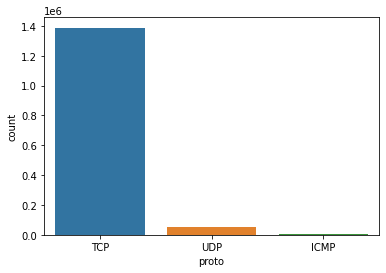

In [ ]:
# Checking the distribution of the Protocols used
sns.countplot(x ='proto', data = proto_df)

# Show the plot
plt.show()

<b>Insights:
1. **Distribution of Protocol Used**: The majority of the connections in the sample use the tcp protocol, followed by udp. There are very few connections that utilize other protocols.

In [ ]:
# Filter out non-numeric values (like '-')
iot_23_filtered = df[df['duration'] != '-']
iot_23_filtered['duration'] = iot_23_filtered['duration'].astype(float)

# Distribution of connection duration
fig_duration = px.histogram(iot_23_filtered, x="duration", nbins=100, title="Distribution of Connection Duration")

# Filter out non-numeric values for orig_bytes
iot_23_filtered_bytes = df[df['orig_bytes'] != '-']
iot_23_filtered_bytes['orig_bytes'] = iot_23_filtered_bytes['orig_bytes'].astype(float).astype(int)


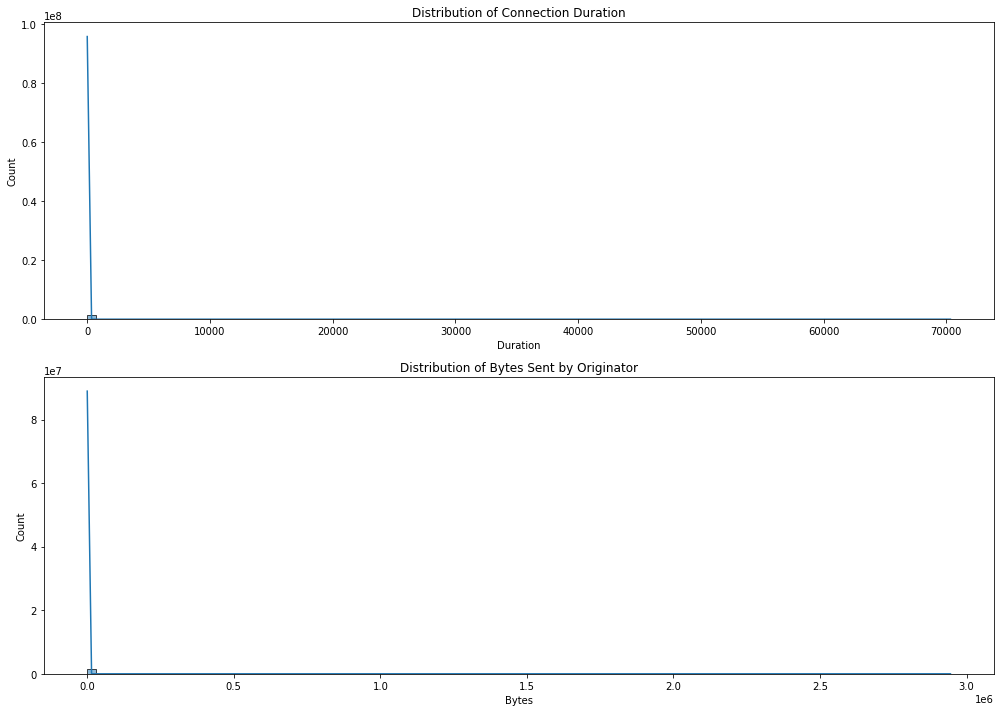

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# Distribution of connection duration
sns.histplot(iot_23_filtered['duration'], bins=100, ax=ax[0], kde=True)
ax[0].set_title('Distribution of Connection Duration')
ax[0].set_xlabel('Duration')
ax[0].set_ylabel('Count')

# Distribution of orig_bytes
sns.histplot(iot_23_filtered_bytes['orig_bytes'], bins=100, ax=ax[1], kde=True)
ax[1].set_title('Distribution of Bytes Sent by Originator')
ax[1].set_xlabel('Bytes')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

<b>Insights:</b>
1. **Distribution of Connection Duration**: Most of the connections have a short duration, with a peak near the start. This could indicate a lot of short-lived connections, possibly signifying network scans or brief exchanges.
2. **Distribution of Bytes Sent by Originator**: The vast majority of connections involve the transmission of a small number of bytes. However, there are a few connections with significantly larger byte transmissions, potentially indicating data exfiltration or large file transfers.

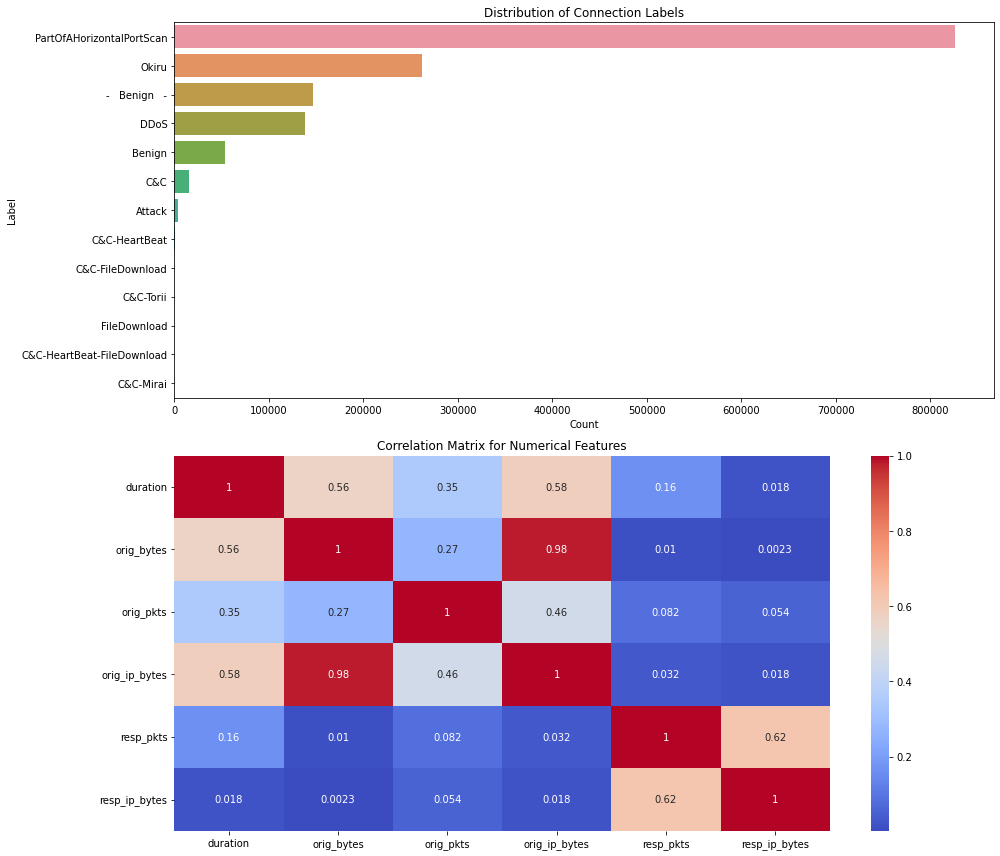

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

# Distribution of label
sns.countplot(data=df, y='label', ax=ax[0], order=df['label'].value_counts().index)
ax[0].set_title('Distribution of Connection Labels')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Label')

# Correlation matrix for numerical features
# Filter out non-numeric values for duration and orig_bytes
correlation_data = iot_23_filtered_bytes[['duration', 'orig_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']]
correlation_data['duration'] = correlation_data['duration'].astype(float)
correlation_data['orig_bytes'] = correlation_data['orig_bytes'].astype(int)
correlation_matrix = correlation_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Correlation Matrix for Numerical Features')

plt.tight_layout()
plt.show()


<b>Insights:</b>
1. **Distribution of Connection Labels**: The data predominantly contains benign connections, but there are several labeled as PartOfAHorizontalPortScan, suggesting instances of scanning activity. There are also a few other labels present in smaller quantities. Also, the labels are needed to be cleaned and merged based on the above plots


2. **Correlation Matrix for Numerical Features**:
    There's a high correlation between orig_pkts (original packets) and orig_ip_bytes (original IP bytes). This makes sense as more packets usually mean more bytes.

    resp_pkts (response packets) and resp_ip_bytes (response IP bytes) also exhibit a high correlation for similar reasons.
    There's a mild correlation between orig_bytes and orig_pkts, indicating that as the byte count increases, the number of packets usually increases.

In [ ]:
# Creating a proto column
def conn_state(df):
    if df['proto_icmp'] ==1:
        return 'ICMP'
    elif df['proto_tcp'] == 1:
        return 'TCP'
    else:
        return 'UDP'


connstate = df.apply(conn_state,axis =1)
conn_state_df = pd.DataFrame(connstate, columns =['conn_state']).reset_index(drop = True)

In [ ]:
# Creating a consolidated conn state data
state_cols = list(df.columns[14:])

def get_state(row):
  for col in state_cols:
    if row[col] == 1:
      return col.split('_')[-1]
  return np.nan

# Apply the function to create a new column
df['conn_state'] = df.apply(get_state, axis=1)

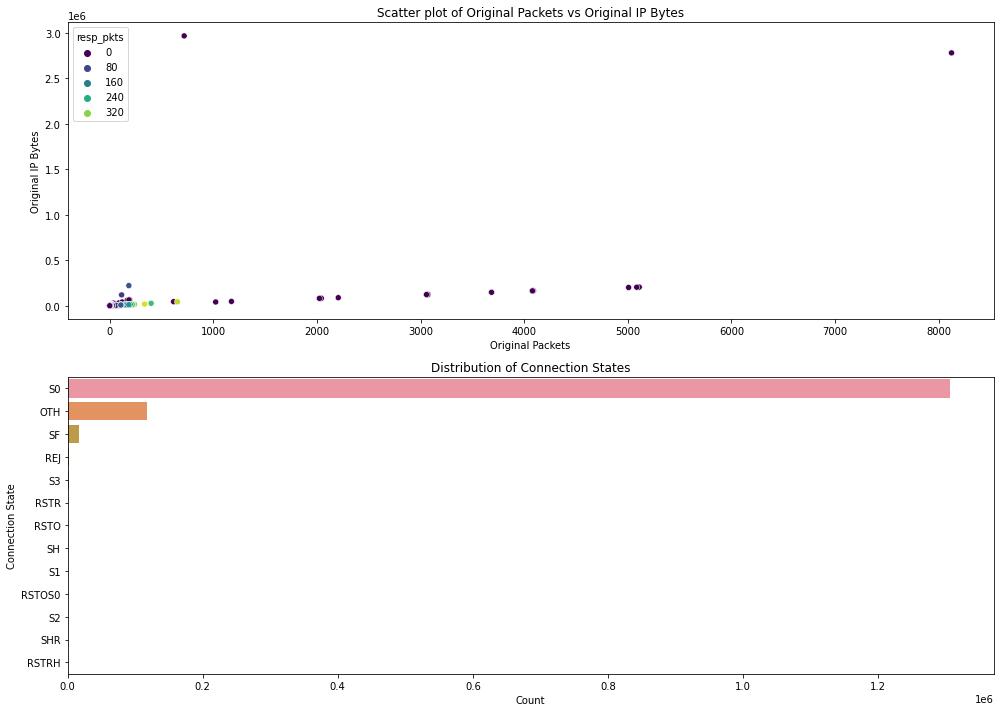

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# Scatter plot of orig_pkts vs orig_ip_bytes
sns.scatterplot(data=correlation_data, x='orig_pkts', y='orig_ip_bytes', hue='resp_pkts', palette='viridis', ax=ax[0])
ax[0].set_title('Scatter plot of Original Packets vs Original IP Bytes')
ax[0].set_xlabel('Original Packets')
ax[0].set_ylabel('Original IP Bytes')

# Distribution of conn_state
sns.countplot(data=df, y='conn_state', ax=ax[1], order=df['conn_state'].value_counts().index)
ax[1].set_title('Distribution of Connection States')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Connection State')

plt.tight_layout()
plt.show()

<b>Insights:</b>

1. **Scatter plot of Original Packets vs Original IP Bytes**: As expected from the correlation matrix, there's a clear trend that as the number of original packets increases, the original IP bytes also increase. The color intensity (representing resp_pkts) adds another dimension, showing that as both original packets and bytes increase, the response packets generally increase.

2. **Distribution of Connection States**: The most frequent connection state is S0, followed by OTH. The S0 state indicates connection attempts where the server never replied to the initial SYN packet from the client. This could be indicative of potential scanning activity.

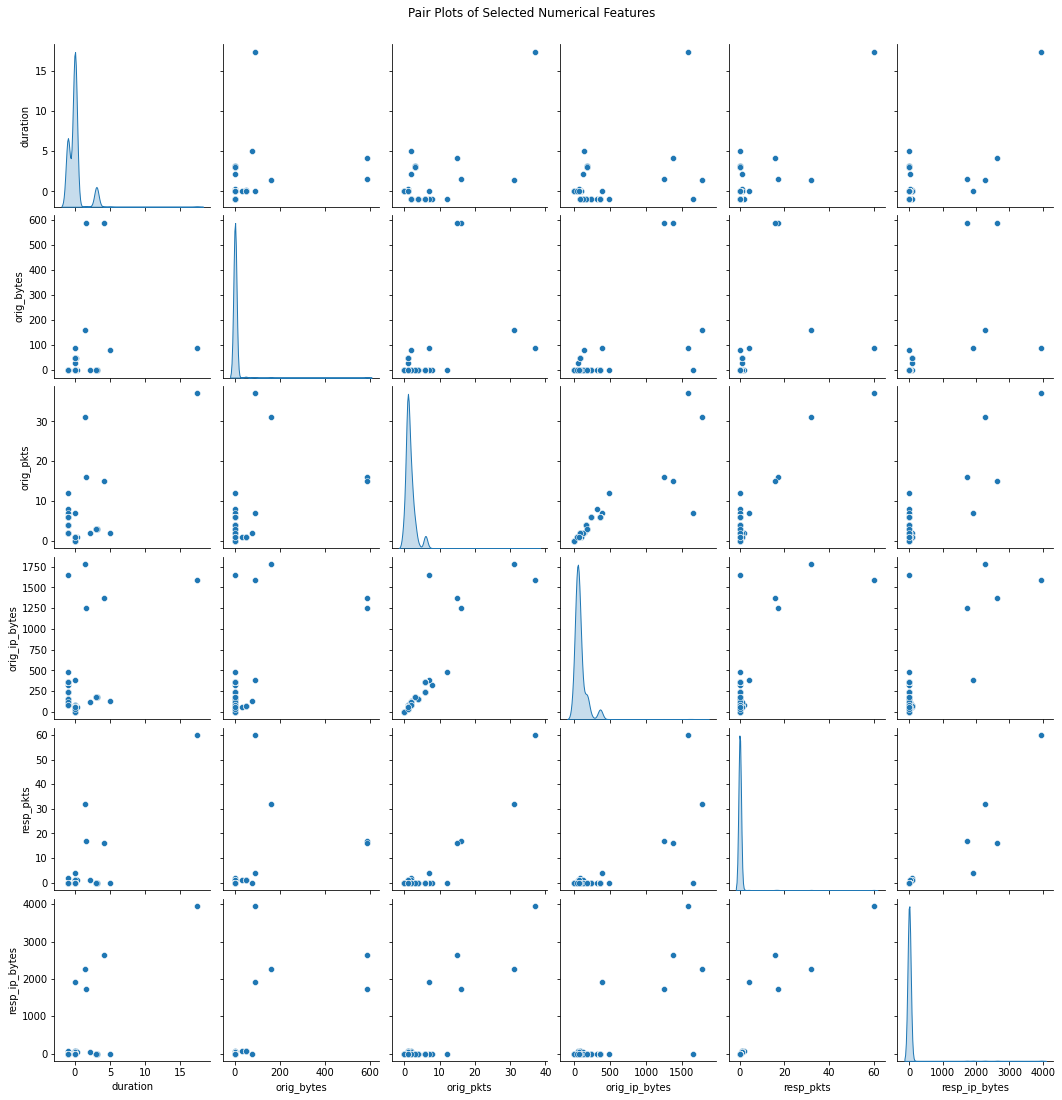

In [ ]:
# Sample a subset of the data for visualization
sample_data = correlation_data.sample(n=min(1000, len(correlation_data)), random_state=42)

# Pair plot for selected numerical features
pairplot = sns.pairplot(sample_data, diag_kind='kde')
pairplot.fig.suptitle('Pair Plots of Selected Numerical Features', y=1.02)
plt.show()

<b>Insights<b>:
1. **Pair Plots of Selected Numerical Features**:
    The diagonal KDE plots confirm our earlier observations regarding the distribution of features.
    
    Scatter plots between orig_pkts vs orig_ip_bytes, and resp_pkts vs resp_ip_bytes show a linear relationship, affirming the correlation we identified earlier.
    
    The other scatter plots provide an opportunity to identify potential patterns or clusters. For instance, there seems to be a cluster at the lower end of orig_bytes vs orig_ip_bytes, indicating a set of connections with small byte counts but varying IP bytes.

<center><h1>Feature Selection and Processing </center>

In [ ]:
df.label.value_counts()

PartOfAHorizontalPortScan     825939
Okiru                         262690
-   Benign   -                146271
DDoS                          138755
Benign                         53475
C&C                            15098
Attack                          3915
C&C-HeartBeat                    349
C&C-FileDownload                  43
C&C-Torii                         25
FileDownload                      12
C&C-HeartBeat-FileDownload         8
C&C-Mirai                          1
Name: label, dtype: int64

In [ ]:
value = 'C&C'

replace_values = {'C&C-HeartBeat':value,
                 'C&C-Torii': value,
                 'C&C-Mirai' : value,
                 'C&C-FileDownload':value,
                 'C&C-HeartBeat-FileDownload':value,
                 'Attack':value,
                 'FileDownload':value,
                 '-   Benign   -' : 'Benign'

                 }

df['label'] = df['label'].map(lambda x: replace_values.get(x, x))

In [ ]:
df

,ts,id.orig_h,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,1.540470e+09,192.168.1.132,0.003497,0.0,0.0,0.0,5.0,212.0,3.0,144.0,...,0,0,0,0,0,0,0,1,0,0
1,1.540470e+09,192.168.1.132,0.036724,34.0,311.0,0.0,1.0,62.0,1.0,339.0,...,0,0,0,0,0,0,0,1,0,0
2,1.540469e+09,192.168.1.132,384.518261,15072.0,0.0,0.0,48.0,16416.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,1.540470e+09,192.168.1.132,0.270332,48.0,48.0,0.0,1.0,76.0,1.0,76.0,...,0,0,0,0,0,0,0,1,0,0
4,1.540470e+09,192.168.1.132,0.111429,48.0,48.0,0.0,1.0,76.0,1.0,76.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446616,1.532526e+09,192.168.100.111,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1446617,1.532526e+09,192.168.100.111,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1446618,1.532526e+09,192.168.100.111,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1446619,1.532526e+09,192.168.100.111,0.000000,0.0,0.0,0.0,1.0,40.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
df.label.value_counts()

PartOfAHorizontalPortScan    825939
Okiru                        262690
Benign                       199746
DDoS                         138755
C&C                           19451
Name: label, dtype: int64

In [ ]:
# Filtering all the rows where the duration of the connection is greater than 0 seconds
df = df[df['duration']!=-1].copy(deep = True)

In [ ]:
# Dropping all un-necessary columns and duraion column as majority of the
df.drop(['ts','id.orig_h' ], axis = 1, inplace =True)

In [ ]:
df['label'].value_counts()

PartOfAHorizontalPortScan    476284
Okiru                        237732
Benign                       199381
DDoS                         113796
C&C                           19267
Name: label, dtype: int64

In [ ]:
# Considering a stratified sample for  modelling
random_state = 4
# Portscan attack sample
df_port = df[df['label']=='PartOfAHorizontalPortScan'].sample(frac = 0.27, random_state = random_state)

# Considering complete Okiru attack category
df_okiru = df[df['label']=='Okiru'].sample(frac=0.55, random_state = random_state)

# Considering complete Benign category
df_benign = df[df['label']=='Benign'].sample(frac=0.65, random_state = random_state)

# Considering complete DDos category
df_ddos = df[df['label']=='DDoS']

# Considering complete C&C category due to low sample size
df_cc = df[df['label']=='C&C']

In [ ]:
df_sample = pd.concat([df_port,df_okiru,df_benign,df_ddos,df_cc], axis =0, ignore_index=True)

In [ ]:
df_sample['label'].value_counts()

Okiru                        130753
Benign                       129598
PartOfAHorizontalPortScan    128597
DDoS                         113796
C&C                           19267
Name: label, dtype: int64

In [ ]:
# Saving the sampled dataframe
df_sample.to_csv('data/iot_23_sample.csv', index = False)

In [17]:
df_sample = pd.read_csv(r'data/iot_23_sample.csv')

In [18]:
df = df_sample.copy(deep = True)

In [19]:
df.columns

Index(['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts',
       'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label', 'proto_icmp',
       'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ',
       'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR',
       'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2',
       'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR'],
      dtype='object')

In [8]:
# Encoding the labels
le = LabelEncoder()
encoded_labels = le.fit_transform(df['label'])
df['label'] = encoded_labels

In [9]:
X = df.loc[:, df.columns != 'label']
y = df['label']

In [10]:
# Performing train test split for the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
# Creating a eval dataset
X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.25, random_state=41)

<h1><center> Modelling and Experimentation </h1></center>

In [ ]:
# Decision tree Classifier
treeclassifier = DecisionTreeClassifier()

In [ ]:
treeclassifier.fit(X_train, y_train)
y_pred = treeclassifier.predict(X_test)
score = treeclassifier.score(X_test,y_test)
print(score)

0.7182575157722664


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78     19313
           1       0.79      0.32      0.45      2806
           2       1.00      1.00      1.00     17235
           3       0.55      1.00      0.71     19603
           4       0.93      0.14      0.24     19345

    accuracy                           0.72     78302
   macro avg       0.80      0.65      0.64     78302
weighted avg       0.80      0.72      0.67     78302



In [ ]:
# XGBoost Classifier
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = []
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(X_train, y_train)
    train_XG.append(xgb_classifier.score(X_train, y_train))
    test_XG.append(xgb_classifier.score(X_test, y_test))

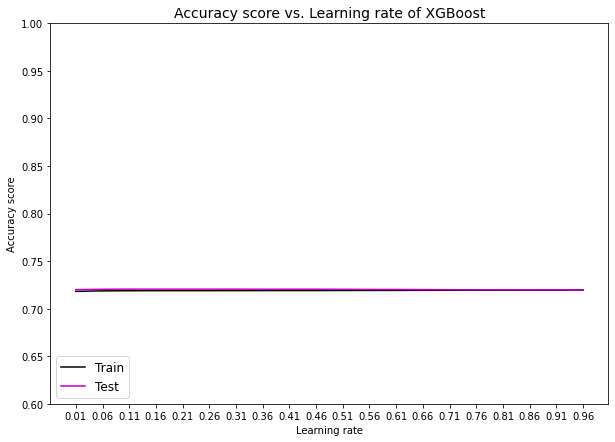

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='black', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

In [ ]:
test_XG

[0.7200199228627622,
 0.7204285969707032,
 0.7205052233659421,
 0.7205052233659421,
 0.720492452300069,
 0.720492452300069,
 0.7205052233659421,
 0.7204285969707032,
 0.7204541391024495,
 0.7204541391024495,
 0.7203775127072105,
 0.720249802048479,
 0.7201987177849863,
 0.7200710071262547,
 0.71993052540165,
 0.7199049832699037,
 0.7198538990064111,
 0.7198028147429184,
 0.7197900436770452,
 0.7197645015452989]

In [ ]:
# Naive Bayse Classifier
clf = GaussianNB()

clf.fit(X_train, y_train)
print('Model Accuracy',clf.score(X_test, y_test))


y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy 0.5344180225281602
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.08      0.15     19313
           1       0.78      0.28      0.41      2806
           2       0.98      1.00      0.99     17235
           3       0.39      1.00      0.57     19603
           4       0.31      0.14      0.19     19345

    accuracy                           0.53     78302
   macro avg       0.69      0.50      0.46     78302
weighted avg       0.66      0.53      0.46     78302



In [ ]:
# Random forest classifier
classifier_rf = RandomForestClassifier(random_state=90, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

classifier_rf.fit(X_train, y_train)
print(classifier_rf.score(X_test, y_test))


y_pred = classifier_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.6968021251053613
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.71     19313
           1       0.92      0.28      0.43      2806
           2       1.00      1.00      1.00     17235
           3       0.55      1.00      0.71     19603
           4       0.48      0.31      0.38     19345

    accuracy                           0.70     78302
   macro avg       0.77      0.63      0.64     78302
weighted avg       0.74      0.70      0.68     78302



In [ ]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))


y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.7175678782151158
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78     19313
           1       0.76      0.31      0.44      2806
           2       1.00      1.00      1.00     17235
           3       0.55      1.00      0.71     19603
           4       0.94      0.14      0.24     19345

    accuracy                           0.72     78302
   macro avg       0.80      0.65      0.63     78302
weighted avg       0.80      0.72      0.66     78302



In [ ]:
# LightGBM Classifier
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

print(model.score(X_test, y_test))

y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 417608, number of used features: 20
[LightGBM] [Info] Start training from score -1.392299
[LightGBM] [Info] Start training from score -3.293510
[LightGBM] [Info] Start training from score -1.525036
[LightGBM] [Info] Start training from score -1.384830
[LightGBM] [Info] Start training from score -1.400824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0.7204669101683226
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     19313
           1       1.00      0.28      0.44      2806
           2       1.

## Insights: Based on the above results, XGBoost seems to outperfrom other algorithms. Hence choosing XGB as candidate model

### Candidate model (XGB) with K-fold cross-validation and hyperparameter tuning including Bayesian Optimization

In [ ]:
# Combining both train and test data
train_df = pd.concat([X_train,X_test], ignore_index=True)

In [ ]:
label_df = pd.concat([y_train,y_test], ignore_index = True)

In [ ]:
# Performing hyperparameter tuning using GridSearch CV
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1}
Best score:  0.7186787598097195


In [ ]:
# Performing Bayesian optimization
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp
import hyperopt

# Define the hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

# Define the objective function to minimize
def objective(params):
    # Convert max_depth to integer
    params['max_depth'] = int(params['max_depth'])

    xgb_model = xgb.XGBClassifier(**params)

    # Use cross-validation for better evaluation
    scores = cross_val_score(xgb_model, train_df, label_df, cv=5, scoring='accuracy')
    mean_score = scores.mean()

    return {'loss': -mean_score, 'status': hyperopt.STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)


100%|██████████████████████████████████████████| 100/100 [11:53:41<00:00, 428.22s/trial, best loss: -0.718969167792543]
Best set of hyperparameters:  {'learning_rate': 0.1269391127675015, 'max_depth': 6.0, 'subsample': 0.9109382577736544}


### Insights : Based on the above Bayesian Optimization, the above are the best set of hyperparameters for us

# Building the Final Candidate Model

In [ ]:
# Defining the model object
model = xgb.XGBClassifier(learning_rate = 0.1269391127675015,
                          max_depth = 6,
                          subsample =  0.9109382577736544,
                          n_jobs =-1)

model.fit(train_df,label_df)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1269391127675015, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [ ]:
# Predictions on the final eval dataset
print('Accuracy:')
print(model.score(X_eval, y_eval))

y_pred = model.predict(X_eval)
print("Classification Report:")
print(classification_report(y_eval, y_pred))

Accuracy:
0.7235738094325888
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79      6508
           1       0.98      0.30      0.46       958
           2       1.00      1.00      1.00      5684
           3       0.55      1.00      0.71      6595
           4       0.95      0.14      0.24      6356

    accuracy                           0.72     26101
   macro avg       0.85      0.65      0.64     26101
weighted avg       0.81      0.72      0.67     26101



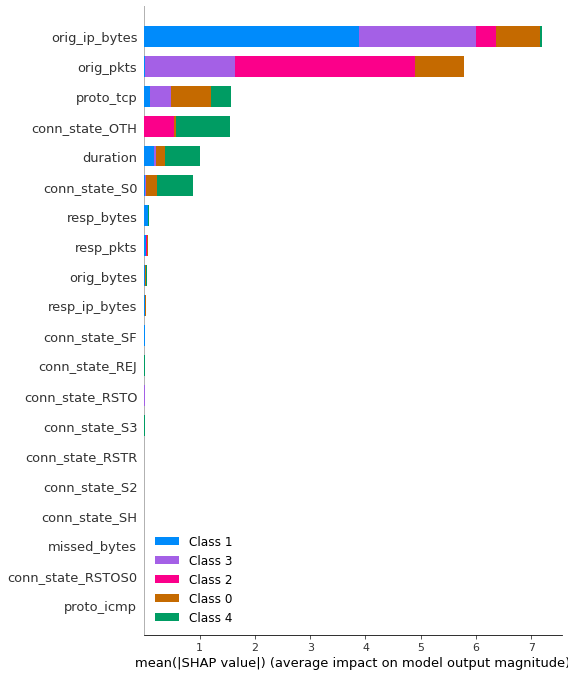

In [ ]:
# Calculatin SHAP feature importance
X_importance = X_eval

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# <center> Binary Class Experimentation </center>

In [12]:
# Decoded labels across the dataset
le.inverse_transform([0,1,2,3,4])

array(['Benign', 'C&C', 'DDoS', 'Okiru', 'PartOfAHorizontalPortScan'],
      dtype=object)

In [13]:
import pandas as pd
import itertools

def generate_binary_class_dfs(df, target_column):
    """
    Generates multiple dataframes for all combinations of binary classes.

    Parameters:
    df (pd.DataFrame): The original dataframe containing multiple classes.
    target_column (str): The name of the column containing the class labels.

    Returns:
    dict: A dictionary where each key is a tuple of class labels and each value is a corresponding dataframe filtered for those classes.
    """
    # Get all unique classes
    unique_classes = df[target_column].unique()

    # Generate all combinations of classes in pairs
    class_combinations = itertools.combinations(unique_classes, 2)

    # Create and store dataframes for each combination
    binary_class_dfs = {}
    for combo in class_combinations:
        # Filter the dataframe for the current combination of classes
        filtered_df = df[df[target_column].isin(combo)]
        binary_class_dfs[combo] = filtered_df

    return binary_class_dfs

In [14]:
# Creating all possible combinations of binary df
binary_df_dict = generate_binary_class_dfs(df,'label')

In [ ]:
def train_and_evaluate(df, target_column, test_size=0.2):

    # Encoding the labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(df[target_column])
    df[target_column] = encoded_labels

    # Splitting the dataset into training and testing sets
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


    # Creating the classifier with general parameters
    model = xgb.XGBClassifier(
        max_depth=6,                # Maximum tree depth for base learners
        learning_rate=0.1,          # Boosting learning rate
        n_estimators=100,           # Number of boosted trees to fit
        subsample=0.8,              # Subsample ratio of the training instance
        colsample_bytree=0.8,
        eval_metric='logloss'       # Evaluation metric for binary classification
    )

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions and evaluating the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_labels = list(le.inverse_transform(sorted(y.unique())))
    report = classification_report(y_test, y_pred, target_names=class_labels)


    return accuracy, report, model, X_test

In [ ]:
for key, value in binary_df_dict.items():
    print('--------------------------------------------------------------------------------------------------')
    print('Binary Classification Evaluation metrics for classes:',key)
    accuracy, report, model, test_set = train_and_evaluate(value,'label')
    print('Accuracy:', accuracy)
    print('Classification Report')
    print(report)
    print('-------------------------------------------------------------------------------------------------- \n \n')


--------------------------------------------------------------------------------------------------
Binary Classification Evaluation metrics for classes: ('PartOfAHorizontalPortScan', 'Okiru')
['Okiru' 'PartOfAHorizontalPortScan']
Accuracy: 0.6584923848081743
Classification Report
                           precision    recall  f1-score   support

                    Okiru       0.60      1.00      0.75     26270
PartOfAHorizontalPortScan       1.00      0.31      0.47     25600

                 accuracy                           0.66     51870
                macro avg       0.80      0.65      0.61     51870
             weighted avg       0.80      0.66      0.61     51870

-------------------------------------------------------------------------------------------------- 
 

--------------------------------------------------------------------------------------------------
Binary Classification Evaluation metrics for classes: ('PartOfAHorizontalPortScan', 'Benign')
['Benign' 'PartOfA

#

# <center> Binary Class Experimentation: Attack vs Benign

In [20]:
df['label'] = df['label'].apply(lambda x: 'Malicious' if x != 'Benign' else 'Benign')

In [21]:
df['label'].value_counts()

Malicious    392413
Benign       129598
Name: label, dtype: int64

In [22]:
df_attack = df[df['label']=='Malicious'].sample(frac = 0.33, random_state= 4)

In [23]:
df_binary = pd.concat([df_attack, df[df['label']=='Benign']], ignore_index= True)

In [25]:
# Encoding the labels
le = LabelEncoder()
encoded_labels = le.fit_transform(df['label'])
df['label'] = encoded_labels

# Splitting the dataset into training and testing sets
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Experiments with KNN Classifier
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))


y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.887503232665728
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78     25821
           1       0.94      0.91      0.92     78582

    accuracy                           0.89    104403
   macro avg       0.84      0.86      0.85    104403
weighted avg       0.89      0.89      0.89    104403



In [27]:
# Experiments with Random forest classifier
classifier_rf = RandomForestClassifier(random_state=90, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

classifier_rf.fit(X_train, y_train)
print(classifier_rf.score(X_test, y_test))


y_pred = classifier_rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.8830014463185923
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.71     25821
           1       0.87      0.99      0.93     78582

    accuracy                           0.88    104403
   macro avg       0.90      0.78      0.82    104403
weighted avg       0.89      0.88      0.87    104403



In [ ]:
# Building the final candidate model using XGBoost
accuracy, report, model, test_set = train_and_evaluate(df_binary,'label')

In [ ]:
print('Accuracy', accuracy)
print('Classification Report \n',report)

Accuracy 0.86919855651402
Classification Report 
               precision    recall  f1-score   support

      Benign       0.90      0.83      0.86     26020
   Malicious       0.84      0.91      0.87     25799

    accuracy                           0.87     51819
   macro avg       0.87      0.87      0.87     51819
weighted avg       0.87      0.87      0.87     51819



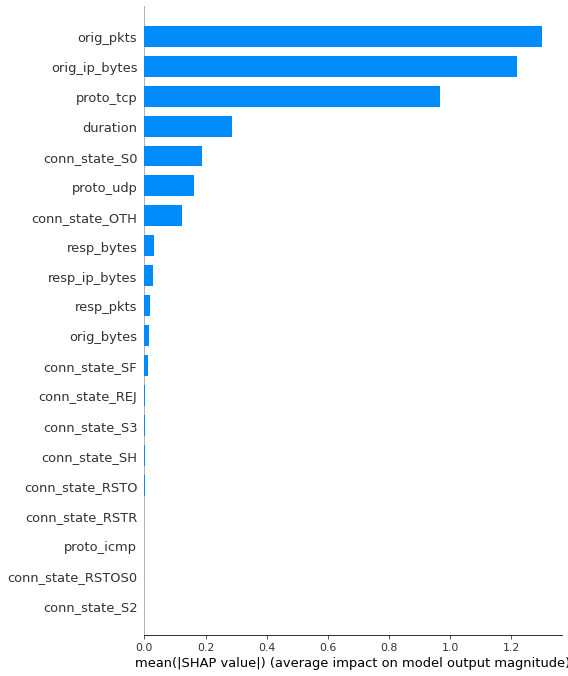

In [ ]:
# Calculatin SHAP feature importance
X_importance = X_eval

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance, plot_type='bar')